# Variational Inference Methods

This notebook is intended to compare three different variational inference methods for approximating complex posterior distributions. The three methods investigated are:

- Fixed-form Variational Inference (FFVI)
- Boosting Variational Inference (BVI)
- Normalizing Flows for Variational Inference (NFVI)

## Overview of Variational Inference

## Boosting Variational Inference

## Normalizing Flows

In [2]:
import torch
import math
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy.optimize import minimize
from torch.utils.data import DataLoader, TensorDataset
import scipy

## Model

Our model is as follows:
\begin{equation}
y(\theta;a) = 
\begin{cases}
  0,& \; -a\leq \theta \leq a \\
  \theta, & \text{else}
\end{cases}
\end{equation}

Where $\theta \sim p_D(\theta)$ and $a \geq 0$. 

### Data Generation
$d$ data samples are generated in the form of $\{ y_i \}_{i=1}^d$ by generating $d$ samples $\{\theta_i \}_{i=1}^d$ and computing $y_i$ for each sample. 

Here, we use $a = 1$ and $p_D(\theta) = N(\mu_D, \sigma^2_D)$

In [124]:
# Define our model (a >= 0 is not checked)
def model(theta):
    a = 0.1
    if ((theta <= a) and (theta >= -a)):
        return 0
    else:
        return np.abs(theta)

(Text(0.5, 0, 'theta'), Text(0, 0.5, 'f'))

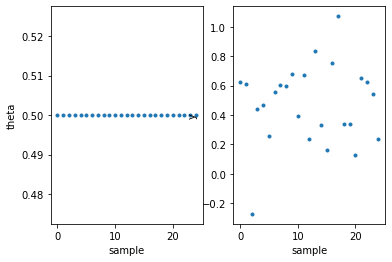

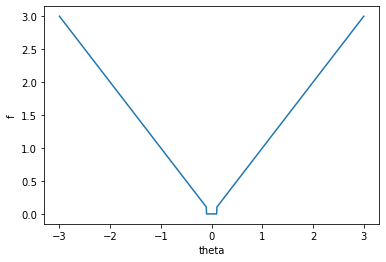

In [150]:
# Define the data generation parameters and generate data

n_samples = 25

mu_d = 0.5   # data generation mean
var_d = 0.0  # data generation variance

theta_d = np.random.normal(mu_d, np.sqrt(var_d), n_samples)
y_d = np.zeros(np.shape(theta_d))

var_xi = 0.25
for i in range(n_samples):
    y_d[i] = model(theta_d[i]) + np.random.normal(0,var_xi)

plt.figure(1)
plt.subplot(1,2,1)
plt.plot(theta_d, '.'), plt.xlabel('sample'), plt.ylabel('theta')
plt.subplot(1,2,2)
plt.plot(y_d, '.'), plt.xlabel('sample'), plt.ylabel('y')

theta_v = np.linspace(-3, 3, 1000)
y_v = np.zeros(np.shape(theta_v))
for i in range(1000):
    y_v[i] = model(theta_v[i]) 
    
plt.figure(2)
plt.plot(theta_v, y_v)
plt.xlabel('theta'), plt.ylabel('f')


### Likelihood Model

We assume that all data is i.i.d and thus
\begin{equation}
p(D|\theta) = \prod_{i=1}^d p(y_i|\theta)
\end{equation}

Where $p(y_i|\theta) = N(y_i; y(\theta), C_D)$ and $C_D$ is the covariance matrix of the data $\{ y_i \}_{i=1}^D$

In [151]:
def logLike(y_d, theta, model):
    # y_d is the data of shape (d,)
    # theta is a scalar [ p(D|theta) ]
    # model is a previously defined function for the model
    
    # Function returns a quantity offset from the true log likelihood (but can be used for optimization purposes,
      # and thus for variational inference methods)
    
    C_D = np.var(y_d)
    s = 0
    for i in range(np.shape(y_d)[0]):
        m = model(theta)
        s -= (y_d[i] - m)**2 / C_D
        
    return s

def prior(theta):
    return np.exp(-theta**2/2)/np.sqrt(2*np.pi)

## Fixed-Form Variational Inference (FFVI)

We approximate the Bayesian posterior $p(\theta|D)$ with a variational posterior $q(\theta)$ of fixed-form. In this tutorial, we assume a Gaussian form on $q(\theta)$ such that
\begin{equation}
q(\theta) = N(\theta; \mu_q, \sigma_q^2)
\end{equation}

We find the variational posterior of this form which is 'closest' to the Bayesian posterior. We define 'closeness' by using the KL divergence, or relative entropy. Yhe optimal variational posterior $q^*(\theta) = N(\mu_q^*, \sigma_q^{*2})$ is found by solving the minimization problem

\begin{equation}
\mu_q^*, \sigma_q^{*2} = \text{argmin}_{\mu_q, \sigma_q^2} D_{KL}[q(\theta)||p(\theta|D)]
\end{equation}

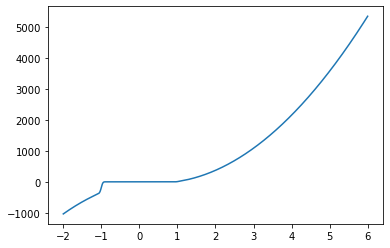

In [152]:
# integral (indefinite) of theta w.r.t. gaussian

def int_1(mu, var, theta):
    return -np.sqrt(var/(2*np.pi))*np.exp(-0.5*(theta-mu)**2/var) - 0.5*mu*scipy.special.erf((mu-theta)/np.sqrt(2*var))
    
# integral (indefinite) of theta^2 w.r.t. gaussian

def int_2(mu, var, theta):
    return -np.sqrt(var/(2*np.pi))*(theta+mu)*np.exp(-0.5*(theta-mu)**2/var) - 0.5*(var+mu**2)*scipy.special.erf((mu-theta)/np.sqrt(2*var))
    

# define the relative entropy computation

def KL(mu, var, y_d):
    # mu is mean of variational posterior
    # var is variance of variational posterior
    # y_d is data
    
    C_D = np.var(y_d)
        
    D = -np.log(np.sqrt(var)) # differential entropy of q(theta)
    
    D = D + 0.5*n_samples*( - int_2(mu,var,-1) - int_2(mu,var,1) )/C_D
    D = D - np.sum(y_d)*( - int_1(mu,var,-1) - int_1(mu,var,1) )/C_D
    
    D = D + (0.5*var+0.5*mu**2) # (prior of N(0,1))
    
    return D

def optim(p):
    # input p[0] = mu
    # input p[1] = log_var
    if p[1]>0:
        return KL(p[0], p[1], y_d)
    else:
        return 1e30

# plot the KL surface with fixed variance
var = .001
mu = np.linspace(-2, 6, 1000)
KL_v = np.zeros(np.shape(mu))


for i in range(1000):
    KL_v[i] = KL(mu[i], var, y_d)

plt.figure(4)
plt.plot(mu, KL_v)
    

In [153]:
# Fixed-form variational inference

p0 = [1.4, .01]
res = minimize(optim, p0, method='nelder-mead')

print("Mean: ", res.x[0])
print("Var: ", res.x[1])

Mean:  -1.226022603829772e+44
Var:  2.01241617490548e+41


(Text(0.5, 0, 'theta'), Text(0, 0.5, 'p(theta)'))

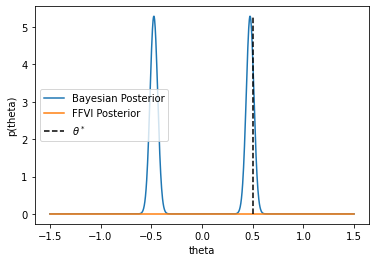

In [154]:
# plot the bayesian posterior vs the FFVI posterior

theta_v = np.linspace(-1.5, 1.5, 1000)
bayes_post_v = np.zeros(np.shape(theta_v))
ffvi_post_v = np.zeros(np.shape(theta_v))
for i in range(len(theta_v)):
    bayes_post_v[i] = np.exp(logLike(y_d, theta_v[i], model))*prior(theta_v[i])
    ffvi_post_v[i] = np.exp(-0.5*((theta_v[i]-res.x[0])**2/res.x[1]))/np.sqrt(2*np.pi*res.x[1])

dtheta = theta_v[1]-theta_v[0]
Z = np.sum(0.5*(bayes_post_v[:-1]+bayes_post_v[1:]))*dtheta

bayes_post_v = bayes_post_v/Z # normalize
    
plt.figure(4)
plt.plot(theta_v, bayes_post_v, label="Bayesian Posterior")
plt.plot(theta_v, ffvi_post_v, label="FFVI Posterior")
plt.plot(np.array([mu_d, mu_d]), np.array([0, np.max(bayes_post_v)]), 'k--', label = r'$\theta^*$')
plt.legend()
plt.xlabel("theta"), plt.ylabel("p(theta)")


## Boosting Variational Inference

In BVI, we iteratively refine an initial estimate of the Bayesian posterior by adding new components to the distribution to form a mixture of the specified base distributions. For example, an initial estimate of the Bayesian posterior is given by
\begin{equation}
  q_0(\theta)
\end{equation}
This initial approximation can be assumed or perhaps computed using FFVI. The distribution is then iteratively refined by adding a new component to the distribution at each step:
\begin{equation}
  q_t(\theta) = (1-\alpha_t)q_{t-1}(\theta) + \alpha_t h_t(\theta)
\end{equation}
Where $h_t$ is a distribution within the allowable class of distributions (e.g. normal) and $\alpha_t$ is the relative weighting between the current mixture and the new mixture component. 

The goal is to minimize KL divergence iteratively. However, solving for both $h_t$ and $\alpha_t$ at the same time is non-convex and unstable. Using a Gaussian family as the base class, $h_t$ is found by a laplace approximation where the mean $\mu_t$ of $h_t$ is found to be
\begin{equation}
\mu_t = \textrm{argmax}_{\mu_t} \log \frac{p(D|\theta)p(\theta)}{q_{t-1}(\theta)}
\end{equation}

This process is described in more detail in: "Boosting Variational Inference" (Guo et al. 2017)



In [130]:
# Define the target function to minimize for finding the mean (Laplace approx.)

def mu_laplace(theta, mu_t, var_t, alpha_t, t):
    logq = np.exp(-0.5*(mu_t[0]-theta)**2/var_t[0])/np.sqrt(2*np.pi*var_t[0])
    for i in range(t):
        logq = alpha_t[i+1]*np.exp(-0.5*(mu_t[i+1]-theta)**2/var_t[i+1])/np.sqrt(2*np.pi*var_t[i+1])+(1-alpha_t[i+1])*logq
        
    logq = np.log(logq+1e-38)
    return logq - logLike(y_d, theta, model) - np.log(prior(theta))


# Function for easier computing of quantities during SGD

def gamma_t(mu_t, var_t, alpha_t, t, theta):
    q = np.exp(-0.5*(mu_t[0]-theta)**2/var_t[0])/np.sqrt(2*np.pi*var_t[0])
    for i in range(t):
        q = alpha_t[i+1]*np.exp(-0.5*(mu_t[i+1]-theta)**2/var_t[i+1])/np.sqrt(2*np.pi*var_t[i+1])+(1-alpha_t[i+1])*q

    h = np.exp(-0.5*(mu_t[t+1]-theta)**2/var_t[t+1])/np.sqrt(2*np.pi*var_t[t+1])
    #if (t > 0):
        #print("q: ", q)
        #print("h: ", h)
        #print("alpha: ", alpha_t[t+1])
    return np.log((1-alpha_t[t+1])*q + alpha_t[t+1]*h + 1e-60) - logLike(y_d, theta, model) - np.log(prior(theta))


# SGD for finding step size (alpha)

def SGD_alpha(mu_t, var_t, alpha_t, t, b, tol, n):
    # mu_t = list of means of components
    # var_t = list of vars of components
    # alpha_t = list of weights
    # t = current iteration
    # b = initial step size
    # tol = convergence tolerence
    # n = number of MC samples for expectation approximation
    
    alpha_new = 0
    alpha_old = 2
    alpha_t[t+1] = alpha_new # store the new alpha in vector
    k = 0
    
    while np.abs(alpha_new - alpha_old) > tol:
    
        # draw samples from new component
        theta_h = np.random.normal(mu_t[t+1], np.sqrt(var_t[t+1]), n) 
    
        # draw samples from old component
        theta_q = np.zeros(n)
        for i in range(n):
            partition = np.random.uniform(0,1,1)
            for j in range(t+1):
                if (partition <= alpha_t[j]*np.prod(1-alpha_t[j+1:t+1])):
                    theta_q[i] = np.random.normal(mu_t[j], np.sqrt(var_t[j]))
                    break
    
        # compute the gradient of KL 
        s = 0
        for i in range(n):
            s += gamma_t(mu_t, var_t, alpha_t, t, theta_h[i]) \
               - gamma_t(mu_t, var_t, alpha_t, t, theta_q[i])
        
        s = s / n
        
        k += 1 # increment the step number
        alpha_old = alpha_new
        alpha_new = alpha_old - b*s/k
        
        # bound the update
        #alpha_new = np.max(np.min(alpha_new,1),0) 
        if alpha_new > 1:
            alpha_new = 1
        if alpha_new < 0:
            alpha_new = 0
            
        alpha_t[t+1] = alpha_new
        
    return alpha_new
    
    
    
    
    
    

In [131]:
# We can use the distribution found in FFVI as the initial approximation

# set some parameters for SGD
b = 5e-3
tol = 1e-2
n = 1

T = 4 # number of iterations

mu_t = np.zeros(T)
mu_t[0] = res.x[0]
var_t = np.zeros(T)
var_t[0] = res.x[1]
alpha_t = np.zeros(T)
alpha_t[0] = 1

dtheta = 1e-5 # for finite difference approximation of the Hessian

plt.figure(9)

for i in range(T-1):
    #print(i)
    
    # first sample from the current distribution (gaussian mixture)
    partition = np.random.uniform(0,1,1)
    for j in range(i+1):
        if (partition <= alpha_t[j]*np.prod(1-alpha_t[j+1:i+1])):
            theta0 = np.random.normal(mu_t[j], np.sqrt(var_t[j]))
            break
    if i==0:
        theta0 = -1.1
    # now find the maximum discrepency measure as the mean of the next component in the mixture
    res_boosting = minimize(mu_laplace, theta0, args=(mu_t, var_t, alpha_t, i), method='nelder-mead')
    
    # assign the new mean
    mu_t[i+1] = res_boosting.x
    
    # find the variance of the component using the Hessian (second-derivative in 1D)
    H = (-2*mu_laplace(mu_t[i+1], mu_t, var_t, alpha_t, i) \
         +mu_laplace(mu_t[i+1]+dtheta, mu_t, var_t, alpha_t, i) \
         +mu_laplace(mu_t[i+1]-dtheta, mu_t, var_t, alpha_t, i))/(dtheta**2)
    
    #th_v = np.linspace(mu_t[i+1] - 10*dtheta, mu_t[i+1]+10*dtheta, 100)
    #h_v = np.zeros(np.shape(th_v))
    #for k in range(len(th_v)):
        #h_v[k] = mu_laplace(th_v[k], mu_t, var_t, alpha_t, i)
    #plt.subplot(T-1, 1, i+1)
    #plt.plot(th_v, h_v)
    
    # assign the computed variance
    var_t[i+1] = 1/(2*H)
    if var_t[i+1] < 1e-5:
        var_t[i+1] = var_t[0] / 5
    
    # find the new weight
    alpha_t[i+1] = SGD_alpha(mu_t, var_t, alpha_t, i, b, tol, n)
    
    

print("Means: ", mu_t)
print("Vars: ", var_t)
print("Alphas: ", alpha_t)


Means:  [-9.97399640e+43 -3.73774414e-01 -1.01432064e+00 -1.01430813e+00]
Vars:  [3.86765784e+41 2.28888041e-03 2.55365432e-05 2.55376829e-05]
Alphas:  [1. 1. 0. 0.]


<ipython-input-130-bbb801f7c8ec>:24: RuntimeWarning: divide by zero encountered in log
  return np.log((1-alpha_t[t+1])*q + alpha_t[t+1]*h + 1e-60) - logLike(y_d, theta, model) - np.log(prior(theta))


<Figure size 432x288 with 0 Axes>

(Text(0.5, 0, 'theta'), Text(0, 0.5, 'p(theta)'))

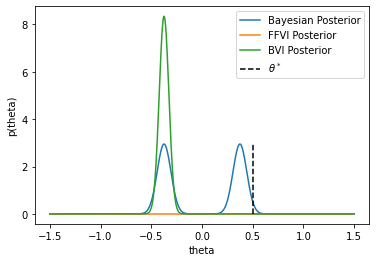

In [132]:
# Now plot the new distribition and some statistics
def compute_q(mu_t, var_t, alpha_t, theta):
    q = np.exp(-0.5*(mu_t[0]-theta)**2/var_t[0])/np.sqrt(2*np.pi*var_t[0])
    for i in range(len(mu_t)-1):
        q = alpha_t[i+1]*np.exp(-0.5*(mu_t[i+1]-theta)**2/var_t[i+1])/np.sqrt(2*np.pi*var_t[i+1])+(1-alpha_t[i+1])*q
    return q

theta_v = np.linspace(-1.5, 1.5, 1000)
bayes_post_v = np.zeros(np.shape(theta_v))
ffvi_post_v = np.zeros(np.shape(theta_v))
bvi_post_v = np.zeros(np.shape(theta_v))
for i in range(len(theta_v)):
    bayes_post_v[i] = np.exp(logLike(y_d, theta_v[i], model))*prior(theta_v[i])
    ffvi_post_v[i] = np.exp(-0.5*((theta_v[i]-res.x[0])**2/res.x[1]))/np.sqrt(2*np.pi*res.x[1])
    bvi_post_v[i] = compute_q(mu_t, var_t, alpha_t, theta_v[i])
     
dtheta = theta_v[1]-theta_v[0]
Z = np.sum(0.5*(bayes_post_v[:-1]+bayes_post_v[1:]))*dtheta

bayes_post_v = bayes_post_v/Z # normalize
        
plt.figure(4)
plt.plot(theta_v, bayes_post_v, label="Bayesian Posterior")
plt.plot(theta_v, ffvi_post_v, label="FFVI Posterior")
plt.plot(theta_v, bvi_post_v, label="BVI Posterior")
plt.plot(np.array([mu_d, mu_d]), np.array([0, np.max(bayes_post_v)]), 'k--', label = r'$\theta^*$')

plt.legend()
plt.xlabel("theta"), plt.ylabel("p(theta)")

## Normalizing Flows




In [134]:
# we first create the base inference network

class encoder(nn.Sequential):
    def __init__(self, layers, nodes, act):
        super(encoder, self).__init__()
        
        self.add_module('full_conn0', nn.Linear(1, nodes))
        self.add_module('act0', act)
        for i in range(layers-1):
            self.add_module('full_conn%d'%(i+1), nn.Linear(nodes, nodes))
            self.add_module('act%d'%(i+1), act)

        
        self.add_module('full_conn%d'%(layers), nn.Linear(nodes, 1))

# now the decoding network (mirrors the encoder)

class decoder(nn.Sequential):
    def __init__(self, layers, nodes, act):
        super(decoder, self).__init__()
        
        self.add_module('full_conn0', nn.Linear(1, nodes))
        self.add_module('act0', act)
        for i in range(layers-1):
            self.add_module('full_conn%d'%(i+1), nn.Linear(nodes, nodes))
            self.add_module('act%d'%(i+1), act)

        
        self.add_module('full_conn%d'%(layers), nn.Linear(nodes, 1))
    

# now define the flow layers

class PlanarFlow(nn.Module):
    def __init__(self, D):
        super().__init__()
        act = torch.tanh
        self.D = D
        self.w = nn.Parameter(torch.empty(D))
        self.b = nn.Parameter(torch.empty(1))
        self.u = nn.Parameter(torch.empty(D))
        self.act = act
        self.act_deriv = lambda x: 1 - torch.tanh(x)**2
        
        nn.init.normal_(self.w)
        nn.init.normal_(self.u)
        nn.init.normal_(self.b)
        
    def forward(self, z):
        dot = torch.sum(self.w*self.u)
        u = self.u + (torch.log(1+torch.exp(dot))-1-dot)*self.w/torch.sum(self.w**2) 
        lin = (z @ self.w + self.b).unsqueeze(1)
        f = z + u * self.act(lin)
        phi = self.act_deriv(lin) * self.w
        log_det = torch.log(torch.abs(1+phi@u))
        
        return f, log_det

class RadialFlow(nn.Module):
    def __init__(self, D):
        super().__init__()
        
        self.D = D
        self.z0 = nn.Parameter(torch.empty(D))
        self.beta = nn.Parameter(torch.empty(1))
        self.alpha = nn.Parameter(torch.empty(1))
        
        nn.init.normal_(self.z0)
        nn.init.normal_(self.alpha)
        nn.init.normal_(self.beta)
        
    def forward(self, z):
        beta = torch.log(1+torch.exp(self.beta)) - torch.abs(self.alpha) # to ensure layer is invertible
        r = torch.linalg.vector_norm(z - self.z0, dim = 1)

        h = beta / (torch.abs(self.alpha) + r)
        h_prime = -beta * r / (torch.abs(self.alpha)+r) ** 2
        f = z + h.unsqueeze(1)*(z-self.z0)

        log_det = (self.D-1) * torch.log(1+h) \
                  + torch.log(1+h+h_prime)       
        return f, log_det 
    
    
class TrueDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, z):
        a = 0.1
        z1 = z + 0.
        z2 = z + 0.
        z1[z1<a] = 0
        z2[z2>-a] = 0
        z2 = -z2
        return z1+z2

In [169]:
# now we can define our model

class NormalizingFlowVI(nn.Module):
    def __init__(self, layers, nodes, flow_layers, act=nn.ReLU()):
        super().__init__()
        
        self.encoder_mean = encoder(layers, nodes, act)
        self.encoder_logvar = encoder(layers, nodes, act)
        self.decoder_mean = TrueDecoder() # decoder(layers, nodes, act)
        self.decoder_logvar = nn.Parameter(torch.empty(1))
        
        self.flow = nn.Sequential()
        #self.flow.add_module('identity', nn.Identity())
        for i in range(flow_layers):
            self.flow.add_module('flow%d'%(i+1), PlanarFlow(1))
    
    def forward(self, x):

        batch_size = x.shape[0]
        zmu, zlogvar = self.encoder_mean(x), self.encoder_logvar(x)
        sigma = torch.exp(0.5*zlogvar)
        z = self._reparameterize(zmu, zlogvar)
        z0 = z.clone()
        
        log_prob_z0 = torch.sum( \
                        -0.5 * torch.log(torch.tensor(2*math.pi)) - \
                            zlogvar - 0.5 * ((z-zmu)/sigma) ** 2, axis = 1)
        
        log_det = torch.zeros((batch_size,))
        for layer in self.flow:
            z, ld = layer(z)
            log_det += ld
         
        log_prob_zk = torch.sum(-0.5 * (torch.log(torch.tensor(2*math.pi)) + z**2), axis = 1)
        
        xmu = self.decoder_mean(z)
        
        log_px_zk = torch.sum(self.gaussian_log_prob(x, xmu, self.decoder_logvar), 1)
        
        return z0, zmu, zlogvar, z, xmu, self.decoder_logvar, \
               log_prob_z0, log_det, log_prob_zk, log_px_zk 
    
    def _reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size()).type_as(mu)
        return mu + std * eps
    
    def gaussian_log_prob(self, x, mu, logvar):
        return -0.5*(math.log(2*math.pi) + logvar + (x-mu)**2/torch.exp(logvar))
    
class Flow(nn.Module):
    def __init__(self, flow_layers, act=nn.ReLU()):
        super().__init__()
        
        self.flow = nn.Sequential()
        #self.flow.add_module('identity', nn.Identity())
        for i in range(flow_layers):
            #if np.mod(i, 2)==0:
            self.flow.add_module('flow%d'%(i+1), RadialFlow(1))
            #else:
            #self.flow.add_module('flow%d'%(i+1), PlanarFlow(1))

    
    def forward(self, zmu, zlogvar):
        batch_size = zmu.shape[0]
        sigma = torch.exp(0.5*zlogvar)
        z = self._reparameterize(zmu, zlogvar)
        z0 = z.clone()
        
        log_prob_z0 = torch.sum( \
                        -0.5 * torch.log(torch.tensor(2*math.pi)) - \
                            zlogvar - 0.5 * ((z-zmu)/sigma) ** 2, axis = 1)
        
        log_det = torch.zeros((batch_size,))
        for layer in self.flow:
            z, ld = layer(z)
            log_det += ld
         
        log_prob_zk = torch.sum(-0.5 * (torch.log(torch.tensor(2*math.pi)) + z**2), axis = 1) # prior of N(0,1)
        
        return z0, zmu, zlogvar, z, \
               log_prob_z0, log_det, log_prob_zk
    
    def _reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size()).type_as(mu)
        return mu + std * eps
    
    def gaussian_log_prob(self, x, mu, logvar):
        return -0.5*(math.log(2*math.pi) + logvar + (x-mu)**2/torch.exp(logvar))

In [170]:
# now load the data and train the model

flow_layers = 100

zmu = 0
zlogvar = 1

C_D = np.var(y_d)

batch_size = n_samples // 1
epochs = 20000

ForwardModel = TrueDecoder()

# process the data
dataset = TensorDataset(torch.tensor(theta_d).unsqueeze(1).float(), \
                        torch.tensor(y_d).unsqueeze(1).float())
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# initialize the model and optimizer
NF = Flow(flow_layers)
optimizer = torch.optim.Adam(NF.parameters(), lr=0.0003)

# initialize loss list
loss_v = np.zeros((epochs,))
NF.train()
# train
for epoch in range(epochs):
    for n, (_, y) in enumerate(data_loader):
        b = y.shape[0]
        
        NF.zero_grad()
        zMu = zmu*torch.ones((b,1))
        zLV = zlogvar*torch.ones((b,1))
        _,_,_,z, lpz0, ld, lpzk = NF.forward(zMu, zLV) 
        
        y_h = ForwardModel(z)
        lr = torch.sum(-0.5*(math.log(2*math.pi) + C_D + (y_h-y)**2/C_D), 1)
        
        loss = torch.mean(lpz0 - lpzk - ld - lr)
        #print(np.shape(lpz0-lpzk-ld-lr))
        
        loss.backward()
        optimizer.step()
        
    loss_v[epoch] = loss.detach().numpy()
        
    if np.mod(epoch, epochs//25)==0:
        print('Epoch: ', epoch)
        print('Loss: ', loss.detach().numpy())
        #print('lpz0: ', lpz0)
        #print('ld: ', ld)
        #print('lpzk: ', lpzk)
        #print('lr: ', lr)
    
    
    


Epoch:  0
Loss:  27.870493
Epoch:  800
Loss:  2.3250616
Epoch:  1600
Loss:  2.1076128
Epoch:  2400
Loss:  1.5207745
Epoch:  3200
Loss:  1.8513943
Epoch:  4000
Loss:  1.9824498
Epoch:  4800
Loss:  2.179053
Epoch:  5600
Loss:  1.4325082
Epoch:  6400
Loss:  1.9236472
Epoch:  7200
Loss:  2.0239108
Epoch:  8000
Loss:  1.6983938
Epoch:  8800
Loss:  1.7053025
Epoch:  9600
Loss:  1.7078607
Epoch:  10400
Loss:  1.8755089
Epoch:  11200
Loss:  1.7424343
Epoch:  12000
Loss:  1.6574492
Epoch:  12800
Loss:  1.6817613
Epoch:  13600
Loss:  1.8149045
Epoch:  14400
Loss:  1.9182489
Epoch:  15200
Loss:  1.8568769
Epoch:  16000
Loss:  1.9259534
Epoch:  16800
Loss:  1.6630502
Epoch:  17600
Loss:  1.4620712
Epoch:  18400
Loss:  1.716154
Epoch:  19200
Loss:  1.8195146


KL:  1.4682812690734863
Learned Model:  Flow(
  (flow): Sequential(
    (flow1): RadialFlow()
    (flow2): RadialFlow()
    (flow3): RadialFlow()
    (flow4): RadialFlow()
    (flow5): RadialFlow()
    (flow6): RadialFlow()
    (flow7): RadialFlow()
    (flow8): RadialFlow()
    (flow9): RadialFlow()
    (flow10): RadialFlow()
    (flow11): RadialFlow()
    (flow12): RadialFlow()
    (flow13): RadialFlow()
    (flow14): RadialFlow()
    (flow15): RadialFlow()
    (flow16): RadialFlow()
    (flow17): RadialFlow()
    (flow18): RadialFlow()
    (flow19): RadialFlow()
    (flow20): RadialFlow()
    (flow21): RadialFlow()
    (flow22): RadialFlow()
    (flow23): RadialFlow()
    (flow24): RadialFlow()
    (flow25): RadialFlow()
    (flow26): RadialFlow()
    (flow27): RadialFlow()
    (flow28): RadialFlow()
    (flow29): RadialFlow()
    (flow30): RadialFlow()
    (flow31): RadialFlow()
    (flow32): RadialFlow()
    (flow33): RadialFlow()
    (flow34): RadialFlow()
    (flow35): RadialFlo

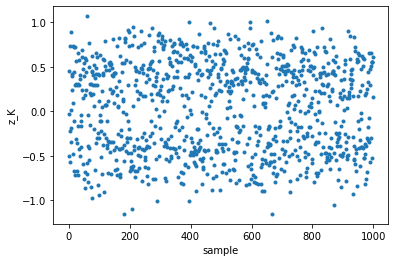

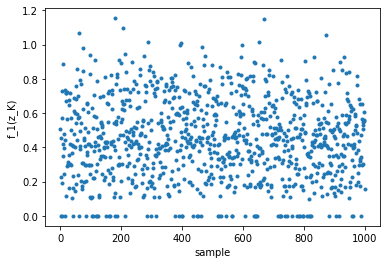

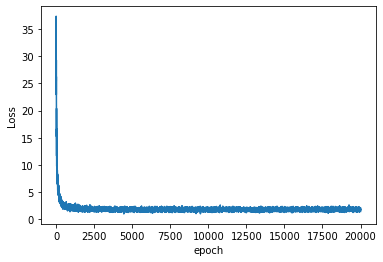

In [171]:
M = 1000
zMu = 0*torch.ones((M,1))
zLV = 1*torch.ones((M,1))
_,_,_,z,_,_,_ = NF.forward(zMu, zLV)

y_out = ForwardModel(z)
y_out = y_out.detach().numpy()
plt.figure(10)
plt.plot(z[:,0].detach().numpy(), '.')
plt.xlabel('sample')
plt.ylabel('z_K')
plt.figure(1)
plt.plot(y_out[:,0],'.')
plt.xlabel('sample')
plt.ylabel('f_1(z_K)')
plt.figure(2)
plt.plot(loss_v)
plt.xlabel('epoch')
plt.ylabel('Loss')
print("KL: ", loss_v[-1])
print("Learned Model: ", NF)

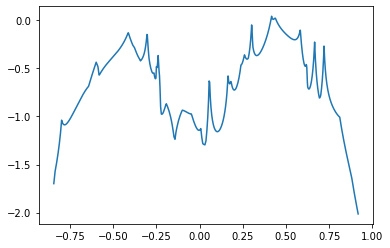

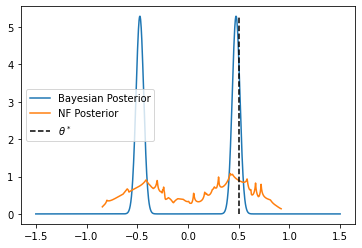

In [172]:
n_s = 1000
z_eval = np.linspace(-3.5, 3.5, n_s)
z_eval_bayes = np.linspace(-1.5, 1.5, n_s)
z_eval_torch = torch.Tensor(z_eval)
zmu0 = 0*torch.ones((1,))
zlogvar0 = 1*torch.ones((1,))
sigma = torch.exp(0.5*zlogvar0)

log_prob_z0 = 0

zprob = np.zeros(np.shape(z_eval))
bayes_post_v = np.zeros(np.shape(z_eval))
zk = np.zeros(np.shape(z_eval))
for i in range(len(z_eval)):
    z = torch.tensor(z_eval[i]).reshape(1,1).float()
    log_prob_z0 = -0.5 * torch.log(torch.tensor(2*math.pi)) - \
                            0.5*zlogvar0 - 0.5 * ((z_eval[i]-zmu0)/sigma) ** 2
        
    log_det = torch.zeros((1,))
    for layer in NF.flow:
        z, ld = layer(z+0.)
        log_det += ld
    zk[i] = z
    zprob[i] = (torch.sum(log_prob_z0 - log_det).detach().numpy())
    bayes_post_v[i] = np.exp(logLike(y_d, z_eval_bayes[i], model))*prior(z_eval_bayes[i])
    
dtheta = z_eval_bayes[1]-z_eval_bayes[0]
Z = np.sum(0.5*(bayes_post_v[:-1]+bayes_post_v[1:]))*dtheta

bayes_post_v = bayes_post_v/Z # normalize
            
# we now sort the NF output
sort_inds = np.argsort(zk)
zk = zk[sort_inds]
zprob = zprob[sort_inds]
    
# now normalize the posterior (not log posterior)
nf_post = np.exp(zprob-3.00e1)
Z = np.sum(0.5*(nf_post[:-1]+nf_post[1:])*np.diff(zk))
nf_post = nf_post/Z

# clip the output for better plotting
nf_post[nf_post > 3.0*np.max(bayes_post_v)] = 3.0*np.max(bayes_post_v)

plt.figure(1)
plt.plot(zk, zprob)
plt.figure(2)
plt.plot(z_eval_bayes, bayes_post_v, label="Bayesian Posterior")
plt.plot(zk, nf_post, label="NF Posterior")
plt.plot(np.array([mu_d, mu_d]), np.array([0, np.max(bayes_post_v)]), 'k--', label = r'$\theta^*$')


plt.legend()

